# Analyzing Sentinel-2 time series across fire histories

This notebook represents the analysis associated with the Remote Sensing publication titled 'Using Sentinel-2 Imagery to Measure Spatiotemporal Changes and Recovery across Three Adjacent Grasslands with Different Fire Histories.'

- doi: https://doi.org/10.3390/rs16122232
- repo: https://github.com/annietaylor/RS_grassland_fire

Notebook authored by Annalise Taylor 2023-2024.

To cite: Taylor, Annalise, Iryna Dronova, Alexii Sigona, and Maggi Kelly. 2024. "Using Sentinel-2 Imagery to Measure Spatiotemporal Changes and Recovery across Three Adjacent Grasslands with Different Fire Histories" Remote Sensing 16, no. 12: 2232. https://doi.org/10.3390/rs16122232

In [1]:
import numpy as np
import pandas as pd
import altair as alt
import io
from IPython.display import display, HTML
import ee
import geemap
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas
import os
from scipy import stats
import scikit_posthocs as sp

#### Authorize to your earth engine account

In [2]:
# ee.Authenticate(auth_mode='localhost')

In [3]:
# insert your ee username here
# ee.Initialize()
ee.Initialize(project='ee-annalisertaylor')

### Import shapefiles

In [4]:
field_shp = 'data/StudyAreas_Clip_ForEE.shp'
field = geemap.shp_to_ee(field_shp)

# separate into features
wildfire = field.filter(ee.Filter.eq('Site', 'Wildfire')).first().geometry()
rxfire = field.filter(ee.Filter.eq('Site', 'Rx')).first().geometry()
nofire = field.filter(ee.Filter.eq('Site', 'No fire')).first().geometry()

# Sentinel-2 pixels with cover class info from zonal statistics of my cover classification
cover_pixels_shp = 'data/S2pixels_StudyArea_2_withCover.shp'
cover_pixels = geemap.shp_to_ee(cover_pixels_shp)
cover_polys_shp = 'data/S2pixels_StudyArea_2_withCover_Diss.shp'
cover_polys = geemap.shp_to_ee(cover_polys_shp)

# For clipping and exporting images
clip_shp = 'data/ImageClipping.shp'
clip_poly = geemap.shp_to_ee(clip_shp)

### Visualization params

In [5]:
# Sentinel-2 RGB
rgbVis = {
  'min': 400,
  'max': 1500,
  'bands': ['B4', 'B3', 'B2'],
}

# NDVI values
palette = ['#d73027','#f46d43','#fdae61','#fee08b','#ffffbf','#d9ef8b','#a6d96a','#66bd63','#1a9850']
ndviVis = {'min':-0.2, 'max': 0.8,  'palette': palette}

# Amplitude
vizNDamp = {'min': 0, 'max': 0.8, 'palette': palette}
vizEVIamp = {'min': -10, 'max': 45, 'palette': palette}

# Max
vizNDmax = {'min': 0.2, 'max': 0.9, 'palette': palette}
vizEVImax = {'min': -40, 'max': 50, 'palette': palette}

visMeanEVI = {'min': -10, 'max': 10, 'palette': ['white', 'green']}

vizRBR = {'min': -0.1, 'max': 0.8, 'palette': ["ffffcc","ffeda0","fed976","feb24c","fd8d3c","fc4e2a","e31a1c","bd0026","800026"]}

# 1. Process Sentinel-2 Imagery

### Cloud mask Sentinel-2 images

In [6]:
startDate = ee.Date.fromYMD(2015, 1, 1) # S2 starts on 2015-06-23
endDate = ee.Date.fromYMD(2023, 10, 1) # last end of water year in my study period

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
  .filter(ee.Filter.date(startDate, endDate)) \
  .filter(ee.Filter.bounds(field)) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))

# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(field)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

### Add VIs

In [7]:
def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR'))
    image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI'))
    image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    return image

def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image

originalCollection = s2_cldmsk.map(addVIs).map(addNBR_RS)
# print(originalCollection.size().getInfo())
# print(originalCollection.first().bandNames().getInfo())

### Investigate time series for issues
I used geemap's time slider to look for images that still contained cloudy pixels within my study area or images for which there were only a few pixels remaining in the study area following pixel-wise cloud filtering. Small numbers of pixels on a given date create lots of noise in the time series. 

In [8]:
test1 = originalCollection.filterDate('2020-02-28', '2020-03-01').first()
test2 = s2.filterDate('2020-02-28', '2020-03-01').first()
test3 = originalCollection.filterDate('2021-05-18', '2021-05-20').first()
test4 = s2.filterDate('2021-05-18', '2021-05-20').first()
test5 = originalCollection.filterDate('2020-03-24', '2020-03-26').first()
test6 = s2.filterDate('2020-03-24', '2020-03-26').first()
test7 = originalCollection.filterDate('2022-12-04', '2022-12-06').first()
test8 = s2.filterDate('2022-12-04', '2022-12-06').first()
test9 = s2.filterDate('2022-11-04', '2022-11-30').first()

# map with individual test images added
m = geemap.Map()
m.add("basemap_selector")
m.addLayer(field, name='Study Area')
m.addLayer(test1, rgbVis, 'Feb 29 2020: cloud filtered', False)
m.addLayer(test2, rgbVis, 'Feb 29 2020: original image', False)
m.addLayer(test3, rgbVis, 'May 19 2021: cloud filtered', False)
m.addLayer(test4, rgbVis, 'May 19 2021: original image', False)
m.addLayer(test5, rgbVis, 'March 25 2020: cloud filtered', False)
m.addLayer(test6, rgbVis, 'March 25 2020: original image', False)
m.addLayer(test7, rgbVis, 'Dec 5 2022: cloud filtered', False)
m.addLayer(test8, rgbVis, 'Dec 5 2022: original image', False)
m.addLayer(test9, rgbVis, 'november 2022', False)
m.centerObject(field, 15)
m

# map with time slider, change years
# m = geemap.Map()
# m.add("basemap_selector")
# m.centerObject(field, 15)
# m.add_time_slider(originalCollection.filterDate('2023','2024'), rgbVis, time_interval=4)
# m.addLayer(ee.Image().toByte().paint(field, 0, 2), {'palette': '111111'}, 'Study Area')
# m

Map(center=[37.14381207121919, -122.34026196646742], controls=(WidgetControl(options=['position', 'transparent…

### Remove incomplete or noisy images from the time series

In [9]:
excludeIDs = [
    '20210519T184921_20210519T190224_T10SEG',
    '20200229T185319_20200229T190002_T10SEG',
    '20200325T185011_20200325T185014_T10SEG',
    '20200807T184919_20200807T185448_T10SEG',
    '20211215T185811_20211215T190030_T10SEG',
    '20220817T184919_20220817T190327_T10SEG',
    '20221031T185531_20221031T185527_T10SEG',
    '20230129T185631_20230129T185751_T10SEG',
    '20230320T185101_20230320T190243_T10SEG',
    '20230504T184919_20230504T185723_T10SEG',
    '20230529T184921_20230529T190101_T10SEG',
    '20190224T185349_20190224T190232_T10SEG',
    '20190430T184921_20190430T185638_T10SEG',
    '20190629T184921_20190629T185707_T10SEG',
    '20190704T184929_20190704T190019_T10SEG',
    '20190828T184921_20190828T185739_T10SEG',
    '20190907T184921_20190907T185437_T10SEG',
    '20190922T185059_20190922T190232_T10SEG',
    '20191121T185659_20191121T190140_T10SEG',
    '20191231T185759_20191231T185800_T10SEG',
    '20200125T185641_20200125T190346_T10SEG',
    '20200130T185619_20200130T190034_T10SEG',
    '20200214T185451_20200214T190205_T10SEG',
    '20200509T184919_20200509T190344_T10SEG',
    '20200529T184919_20200529T190015_T10SEG',
    '20200812T184921_20200812T185701_T10SEG',
    '20200827T184919_20200827T185937_T10SEG',
    '20201230T185811_20201230T190030_T10SEG',
    '20201230T185811_20201230T190030_T10SEG',
    '20210218T185431_20210218T190349_T10SEG',
    '20210305T185239_20210305T190316_T10SEG',
    '20210315T185039_20210315T185348_T10SEG',
    '20210409T184911_20210409T185339_T10SEG',
    '20210603T184919_20210603T185928_T10SEG',
    '20210623T184919_20210623T190308_T10SEG',
    '20210718T184921_20210718T185405_T10SEG',
    '20210817T184921_20210817T190331_T10SEG',
    '20210901T184919_20210901T185931_T10SEG',
    '20211026T185501_20211026T190310_T10SEG',
    '20211031T185529_20211031T190014_T10SEG',
    '20220419T184909_20220419T185516_T10SEG',
    '20220713T184931_20220713T185914_T10SEG',
    '20220802T184931_20220802T185619_T10SEG',
    '20220911T184951_20220911T190232_T10SEG',
    '20220921T185101_20220921T190057_T10SEG',
    '20221215T185809_20221215T190249_T10SEG',
    '20230223T185359_20230223T185516_T10SEG',
    '20230524T184919_20230524T185547_T10SEG',
    '20230603T184919_20230603T190256_T10SEG',
    '20230628T184921_20230628T190304_T10SEG',
    '20230708T184921_20230708T185910_T10SEG'
]

for imageID in excludeIDs: 
    originalCollection = originalCollection.filter(ee.Filter.neq('system:index', imageID))

print(originalCollection.size().getInfo())

263


### Moving window smoothing
Adapted from Ujaval Gandhi of Spatial Thoughts: https://courses.spatialthoughts.com/end-to-end-gee-supplement.html#moving-window-smoothing

In [10]:
# Specify the time-window
days = 30

# Convert to milliseconds
millis = ee.Number(days).multiply(1000*60*60*24)

# We use a 'save-all join' to find all images that are within the time-window
# The join will add all matching images into a new property called 'images'
join = ee.Join.saveAll('images')

# This filter will match all images that are captured
# within the specified day of the source image
diffFilter = ee.Filter.maxDifference(difference=millis, leftField='system:time_start', rightField='system:time_start')

joinedCollection = join.apply(originalCollection, originalCollection, diffFilter)

# print('Joined Collection', joinedCollection)

# Each image in the joined collection will contain matching images in the 'images' property
# Extract and return the mean of matched images
def extractAndComputeMean(image):
    matchingImages = ee.ImageCollection.fromImages(image.get('images'))
    meanImage = matchingImages.reduce(ee.Reducer.mean().setOutputs(['moving_average']))
    return ee.Image(image).addBands(meanImage)

smoothedCollection = ee.ImageCollection(joinedCollection.map(extractAndComputeMean))

# pprint(smoothedCollection.getInfo())
# pprint(smoothedCollection.first().bandNames().getInfo())
# pprint(smoothedCollection.first().propertyNames().getInfo())
pprint(smoothedCollection.size().getInfo())

263


# 2. Full Time Series Analysis

### Full Time Series across regions

Get the average values in TS across the STUDYAREA (three fields) OR COVER_POLYS (3 fields x 3 veg types)

Alternative more efficient reduceRegions

Map over the images, and within that mapped function map over the features

In [20]:
cb = field.filter(ee.Filter.eq('Site', 'Rx')).first().set('Site', 'Controlled Burn')
nf = field.filter(ee.Filter.eq('Site', 'No fire')).first().set('Site', 'No Fire')
wf = field.filter(ee.Filter.eq('Site', 'Wildfire')).first()

studyarea = ee.FeatureCollection([nf, cb, wf]).select('Site')
# print(studyarea.getInfo())

# Can use cover_polys INSTEAD OF studyarea
regions = cover_polys
# regions = studyarea
# select bands you want reduced
VI_smoothed = smoothedCollection.select(['NBR', 'NBR_RS', 'NDVI', 'EVI',\
                                         'NBR_moving_average', 'NBR_RS_moving_average','NDVI_moving_average', 'EVI_moving_average'])
# print(VI_smoothed.first().bandNames().getInfo())

# can reduce by mean or median
# for every image, you get a fc with site, and those mean values as properties.
# result = img.reduceRegions(studyarea, ee.Reducer.mean(), 20)
# need to set Date of each feature in the collection
def RR_all_features(img):
    fc_means = ee.FeatureCollection(img.reduceRegions(regions, ee.Reducer.mean(), 10))
    img_date = img.date().format("MM-dd-YYYY")
    def set_date(feat):
        return feat.set('Date', img_date)
    fc_means = ee.FeatureCollection(fc_means.map(set_date))
    return fc_means

# map over each image in the collection to call reduceRegions
# creates a collection of feature collections, has to be flattened
result = ee.FeatureCollection(VI_smoothed.map(RR_all_features)).flatten()
# pprint(result.first().propertyNames().getInfo())

df = geemap.ee_to_df(result)
df.head()

,Date,EVI,EVI_moving_average,MAJORITY,NBR,NBR_RS,NBR_RS_moving_average,NBR_moving_average,NDVI,NDVI_moving_average,Shape_Area,Shape_Leng,Site_Veg,TREATMENT_
0,12-26-2018,4.285867,1.499982,0,0.071502,0.079658,0.060152,0.056863,0.427530,0.449954,13900,3220,Shrub: Wildfire,CZU ANSR
1,12-26-2018,1.798527,1.209365,0,0.064864,0.064787,0.056737,0.054142,0.404789,0.432798,16800,3080,Shrub: Controlled,Rx Burn
2,12-26-2018,1.916362,1.346537,0,0.228571,0.234369,0.251771,0.251906,0.500725,0.525070,69000,10440,Shrub: No Fire,Unburned North
3,12-26-2018,1.499633,1.645024,1,-0.044085,0.001763,0.185626,0.170390,0.402445,0.613406,1900,600,Tree: Wildfire,CZU ANSR
4,12-26-2018,1.907495,1.505213,1,0.197048,0.208351,0.249343,0.237893,0.513509,0.556134,2700,760,Tree: No Fire,Unburned North


### Prep the dataframe for charting

In [21]:
ts = df
print(ts.shape)
ts.Date = pd.to_datetime(ts.Date, format='%m-%d-%Y')
display(ts.dtypes)
ts.head(10)

(2104, 14)


Date                     datetime64[ns]
EVI                             float64
EVI_moving_average              float64
MAJORITY                          int64
NBR                             float64
NBR_RS                          float64
NBR_RS_moving_average           float64
NBR_moving_average              float64
NDVI                            float64
NDVI_moving_average             float64
Shape_Area                        int64
Shape_Leng                        int64
Site_Veg                         object
TREATMENT_                       object
dtype: object

,Date,EVI,EVI_moving_average,MAJORITY,NBR,NBR_RS,NBR_RS_moving_average,NBR_moving_average,NDVI,NDVI_moving_average,Shape_Area,Shape_Leng,Site_Veg,TREATMENT_
0,2018-12-26,4.285867,1.499982,0,0.071502,0.079658,0.060152,0.056863,0.427530,0.449954,13900,3220,Shrub: Wildfire,CZU ANSR
1,2018-12-26,1.798527,1.209365,0,0.064864,0.064787,0.056737,0.054142,0.404789,0.432798,16800,3080,Shrub: Controlled,Rx Burn
2,2018-12-26,1.916362,1.346537,0,0.228571,0.234369,0.251771,0.251906,0.500725,0.525070,69000,10440,Shrub: No Fire,Unburned North
3,2018-12-26,1.499633,1.645024,1,-0.044085,0.001763,0.185626,0.170390,0.402445,0.613406,1900,600,Tree: Wildfire,CZU ANSR
4,2018-12-26,1.907495,1.505213,1,0.197048,0.208351,0.249343,0.237893,0.513509,0.556134,2700,760,Tree: No Fire,Unburned North
5,2018-12-26,1.461309,1.012066,2,-0.030964,-0.035583,-0.000638,-0.000091,0.338377,0.379385,300100,8360,Grass: Wildfire,CZU ANSR
6,2018-12-26,1.880609,1.277815,2,0.039536,0.038825,0.039326,0.039677,0.375005,0.413912,407300,7780,Grass: Controlled,Rx Burn
7,2018-12-26,1.908465,1.159251,2,0.187969,0.187957,0.190107,0.190792,0.470422,0.477366,113100,11080,Grass: No Fire,Unburned North
8,2018-12-31,1.008808,1.446126,0,0.003320,0.006136,0.051177,0.048035,0.476251,0.460564,13900,3220,Shrub: Wildfire,CZU ANSR
9,2018-12-31,0.964377,1.276561,0,0.011997,0.017621,0.087312,0.083638,0.464508,0.466541,16800,3080,Shrub: Controlled,Rx Burn


In [22]:
# Run this block when using cover_polys
# restructures the df so that the figure draws correctly

ts['Site'] = 'No Fire'
ts.loc[ts['TREATMENT_'] == 'CZU ANSR', 'Site'] = 'Wildfire'
ts.loc[ts['TREATMENT_'] == 'Rx Burn', 'Site'] = 'Controlled Burn'

ts['Vegetation'] = 'Grass'
ts.loc[ts['Site_Veg'].str.contains('Shrub'), 'Vegetation'] = 'Shrub'
ts.loc[ts['Site_Veg'].str.contains('Tree'), 'Vegetation'] = 'Tree'

#### Prep the fire data

In [14]:
# CZU Wildfire (8/16/2020 to 9/6/2020)
# Cultural Burn (11/19/2020)
# Controlled Burn (11/7/2017)

# create vertical bars to display fires
# If using TOA imagery, add back the 2017 controlled burn too
fires = [
#     {"start": "2017-10-25", "end": "2017-11-10", "event": "Controlled Burn"},
    {"start": "2020-11-05", "end": "2020-11-20", "event": "Controlled Burn"},
    {"start": "2020-08-16", "end": "2020-09-06", "event": "Wildfire"}
]

fires = pd.DataFrame(fires)

fdom = ['Controlled Burn', 'Wildfire'] 
frng = ['#FFAB07', '#BD2E2E'] 

# fire boxes
rect = alt.Chart(fires).mark_rect(opacity=0.4).encode(
    x='start:T',
    x2='end:T',
    color=alt.Color('event', scale=alt.Scale(domain=fdom, range=frng), legend=None)
)

#### Choose colors based on which regions you're using
This is set in a code block a few above this with regions = studyarea or coverpolys

In [23]:
if regions == studyarea: #change alt.Color and Alt.Tooltip to 'Site' instead of 'Site_Veg'
    dom = ['No Fire', 'Controlled Burn', 'Wildfire']
    rng = ['#12A7B3', '#FFAB07', '#BD2E2E']
#     rng = ['darkorange', 'firebrick', 'slateblue'] # old colors correspond to old order
else: #change alt.Color and Alt.Tooltip to 'Site_Veg' instead of 'Site'
    dom = ['Grass: Controlled', 'Grass: Wildfire', 'Grass: No Fire', \
           'Shrub: Controlled', 'Shrub: Wildfire', 'Shrub: No Fire'] #, \
#            'Tree: Wildfire', 'Tree: No Fire']
    rng = ['darkgreen', 'teal', 'lightgreen', \
           'saddlebrown', 'darkorange', 'khaki'] #, \
#            'mediumpurple', 'plum']

### NBR raw or moving average across all three sites

In [16]:
# colorpalette = sns.color_palette(['#BD2E2E', '#12A7B3', '#FFAB07'])

# multi series line chart
line = alt.Chart(ts).mark_line().encode(
    x = alt.X('Date', axis=alt.Axis(title='Date', format="%b-%y", labelAngle=-45)),
    # change this between 'NBR' and 'NBR_moving_average' depending on what you want
    y = alt.Y('NBR_RS_moving_average', axis=alt.Axis(title='NBR 30-day Moving Average'), scale=alt.Scale(domain=(-0.6, 0.6))),
    color=alt.Color('Site', legend=alt.Legend(title='Study Area Sites'), scale=alt.Scale(domain=dom, range=rng)),
    tooltip = [
      alt.Tooltip('Date:T', title='Date'), #format='%Y'),
      alt.Tooltip('Site', title='Site'),
      alt.Tooltip('NBR:Q', title='NBR')
    ]
).properties(height=450, width=800).interactive()


# create layered chart
alt.layer(line, rect #rect to add fires, jan, octo, june to add those dates as vertical lines
          ).configure_legend(labelFontSize=14,
                             titleFontSize=14,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='bottom-right'
          ).configure_axis(
                labelFontSize=14,
                titleFontSize=14
          ).interactive().resolve_scale(color='independent')

alt.LayerChart(...)

## NDVI

In [17]:
# display(ts)

# multi series line chart
line = alt.Chart(ts).mark_line().encode(
    x = alt.X('Date', axis=alt.Axis(title='Date', format="%b-%y", labelAngle=-45)),
    y = alt.Y('NDVI_moving_average', axis=alt.Axis(title='NDVI 30-day Moving Average')), # scale=alt.Scale(domain=(1, -1))),
    color=alt.Color('Site', legend=alt.Legend(title='Study Area Sites'), scale=alt.Scale(domain=dom, range=rng)),
    tooltip = [
      alt.Tooltip('Date:T', title='Date'), #format='%Y'),
      alt.Tooltip('Site', title='Site'),
      alt.Tooltip('NDVI:Q', title='NDVI')
    ]
).properties(height=450, width=800).interactive()


# create layered chart
alt.layer(rect, line
          ).configure_legend(labelFontSize=14,
                             titleFontSize=14,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='bottom-right'
          ).configure_axis(
                labelFontSize=14,
                titleFontSize=14
          ).interactive().resolve_scale(color='independent')

alt.LayerChart(...)

### EVI

In [18]:
# multi series line chart
line = alt.Chart(ts).mark_line().encode(
    x = alt.X('Date', axis=alt.Axis(title='Date', format="%b-%y", labelAngle=-45)),
    y = alt.Y('EVI_moving_average', axis=alt.Axis(title='EVI 30-day Moving Average')), # scale=alt.Scale(domain=(1, -1))),
    color=alt.Color('Site', legend=alt.Legend(title='Study Area Sites'), scale=alt.Scale(domain=dom, range=rng)),
    tooltip = [
      alt.Tooltip('Date:T', title='Date'), #format='%Y'),
      alt.Tooltip('Site', title='Site'),
      alt.Tooltip('EVI:Q', title='EVI')
    ]
).properties(height=450, width=800).interactive()


# create layered chart
alt.layer(rect, line
          ).configure_legend(labelFontSize=14,
                             titleFontSize=14,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='bottom-right'
          ).configure_axis(
                labelFontSize=14,
                titleFontSize=14
          ).interactive().resolve_scale(color='independent')

alt.LayerChart(...)

### NBR time series high resolution for figure 2

In [19]:
wftext = alt.Chart({'values':[{'Date': '2020-08-25', 'NBR': 0.47}]}).mark_text(
    text='Wildfire', fontSize=22 #, angle=346
).encode(
    x='Date:T', y='NBR:Q'
)

cbtext = alt.Chart({'values':[{'Date': '2020-11-22', 'NBR': 0.40}]}).mark_text(
    lineBreak=r'\n', text=r'Controlled\nBurn', fontSize=22
).encode(
    x='Date:T', y='NBR:Q'
)

line = alt.Chart(ts).mark_line().encode(
    x = alt.X('Date', axis=alt.Axis(title='Date', format="%b %Y", labelAngle=-45)),
    y = alt.Y('NBR_RS_moving_average', axis=alt.Axis(title='NBR 30-day Moving Average'), scale=alt.Scale(domain=(-0.5, 0.6))),
    color=alt.Color('Site', legend=alt.Legend(title='Study Area Sites'), scale=alt.Scale(domain=dom, range=rng)),
    tooltip = [
      alt.Tooltip('Date:T', title='Date'), #format='%Y'),
      alt.Tooltip('Site', title='Site'),
      alt.Tooltip('NBR:Q', title='NBR')
    ]
).properties(height=600, width=1300).interactive()

# create layered chart
alt.layer(line, rect, wftext, cbtext
          ).configure(font='Calibri'
          ).configure_legend(labelFontSize=22,
                             titleFontSize=22,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='bottom-right'
          ).configure_axis(
                labelFontSize=22,
                titleFontSize=22
          ).interactive().resolve_scale(color='independent')

alt.LayerChart(...)

### NBR by site and veg type - Figure 3
Use this by setting region = cover_polys above

In [24]:
dom1 = ['Grass: Controlled', 'Grass: Wildfire', 'Grass: No Fire', \
       'Shrub: Controlled', 'Shrub: Wildfire', 'Shrub: No Fire']
rng1 = ['darkgreen', 'teal', 'lightgreen', \
       'saddlebrown', 'darkorange', 'khaki']
rng1 = ['#332288', '#6171cf', '#88CCEE', '#117733', '#82a254', '#DDCC77']

domv = ['Grass', 'Shrub']
rngv = ['darkgreen', 'darkorange']
# rng2 = [alt.value([0]), alt.value([5, 5]), alt.value([2, 2]), \
#        alt.value([0]), alt.value([5, 5]), alt.value([2, 2])]

line = alt.Chart(ts).mark_line(strokeWidth=3).encode(
    x = alt.X('Date', axis=alt.Axis(title='Date', format="%b %Y", labelAngle=-45)),
    y = alt.Y('NBR_RS_moving_average', axis=alt.Axis(title='NBR 30-day Moving Average'), scale=alt.Scale(domain=(-0.5, 0.7))),
#     color=alt.Color('Vegetation', scale=alt.Scale(domain=domv, range=rngv)),
    color=alt.Color('Site_Veg', scale=alt.Scale(domain=dom1, range=rng1), title='Vegetation-Site Pairs')
).properties(height=600, width=1300)#.interactive()

fdom = ['Controlled Burn', 'Wildfire'] 
frng = ['#FFAB07', '#BD2E2E'] 

# fire boxes
rect = alt.Chart(fires).mark_rect(color='gray', opacity=0.3).encode(
    x='start:T',
    x2='end:T'
)

wftext = alt.Chart({'values':[{'Date': '2020-08-25', 'NBR': 0.47}]}).mark_text(
    text='Wildfire', fontSize=22, font='Calibri' #, angle=346
).encode(x='Date:T', y='NBR:Q')

cbtext = alt.Chart({'values':[{'Date': '2020-11-20', 'NBR': 0.40}]}).mark_text(
    lineBreak=r'\n', text=r'Controlled\nBurn', fontSize=22, font='Calibri'
).encode(x='Date:T', y='NBR:Q')

# create layered chart
alt.layer(rect, line, wftext, cbtext
          ).configure(font='Calibri'
          ).configure_legend(labelFontSize=20,
                             titleFontSize=20,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='bottom-right',
                             symbolStrokeWidth=4
          ).configure_axis(
                labelFontSize=22,
                titleFontSize=22
          )#.configure(font='Calibri')
#.resolve_scale(color='independent')

alt.LayerChart(...)

# 3. Annual Water Year Metrics

#### Checking bands and start date of SR collection

In [28]:
# smoothedCollection.first().bandNames().getInfo()

# pprint(smoothedCollection.first().get('system:index').getInfo())

### Calculate amplitude, min, and max
Each water year goes from October 1, previous year and ends on September 30 of that year, i.e. water year 2020 goes from Oct 1 2019 to Sept 30 2020. 

system:time_start of each annualized image is equal to the start of the water year, so October 1 2019

If I'm using the SR data, I only have full data for the 2020 water year and beyond. SR data starts 12/26/2018, so I have most of the 2019 water year but not all. I'm including it here but this is a caveat.

The cultural burn occurs at the start of water year 2021
the wildfire occurs at the end of water year 2020

water year 2020 does not include the cultural burn (it's a fully pre-burn water year) 
BUT water year 2020 originally did include the wildfire dip (8/16/2020 to 9/6/2020) (more on this later)
water year 2021 is post-fire for both fires, includes the cultural burn though = October 1 2020 to Sept 30 2021

In [25]:
# Which bands to use in later calculations
VIbands = ['EVI', 'NDVI', 'NBR', 'NBR_RS','EVI_moving_average', 'NDVI_moving_average','NBR_moving_average', 'NBR_RS_moving_average']

# calculate amplitude, defined as 95th percentile minus 5th percentile
def calcAmp(image):
    image = image.addBands(image.expression("b('EVI_moving_average_p95') - b('EVI_moving_average_p5')").rename('EVI_MA_Amp'))
    image = image.addBands(image.expression("b('EVI_p95') - b('EVI_p5')").rename('EVI_Amp'))
    image = image.addBands(image.expression("b('NDVI_moving_average_p95') - b('NDVI_moving_average_p5')").rename('NDVI_MA_Amp'))
    image = image.addBands(image.expression("b('NDVI_p95') - b('NDVI_p5')").rename('NDVI_Amp'))
    image = image.addBands(image.expression("b('NBR_moving_average_p95') - b('NBR_moving_average_p5')").rename('NBR_MA_Amp'))
    image = image.addBands(image.expression("b('NBR_p95') - b('NBR_p5')").rename('NBR_Amp'))
    image = image.addBands(image.expression("b('NBR_RS_moving_average_p95') - b('NBR_RS_moving_average_p5')").rename('NBR_RS_MA_Amp'))
    image = image.addBands(image.expression("b('NBR_RS_p95') - b('NBR_RS_p5')").rename('NBR_RS_Amp'))
#     image = image.addBands(image.expression("b('NDMI_moving_average_p95') - b('NDMI_moving_average_p5')").rename('NDMI_MA_Amp'))
#     image = image.addBands(image.expression("b('NDMI_p95') - b('NDMI_p5')").rename('NDMI_Amp'))
#     image = image.addBands(image.expression("b('NDWI_moving_average_p95') - b('NDWI_moving_average_p5')").rename('NDWI_MA_Amp'))
#     image = image.addBands(image.expression("b('NDWI_p95') - b('NDWI_p5')").rename('NDWI_Amp'))
    return image

# MAPPING OVER LIST OF YEARS
# Can start with 2016 if using the TOA image collection
years = ee.List.sequence(2019, 2023, 1)
yrlist = years.getInfo()
print(yrlist)
# yrliststr = [str(x) for x in yrlist]
# print(yrliststr)

# Calculate 5% and 95% percentile values, amplitude (diff of those)
def mapWaterYearsPerAmp(wateryear):
    startWY = ee.Date.fromYMD(wateryear, 10, 1).advance(-1, 'year')
    endWY = ee.Date.fromYMD(wateryear, 9, 30)
    # Calculate annual amplitude of smoothed collection for all VI bands (smoothed and raw)
    WY = smoothedCollection.filterDate(startWY, endWY) \
                  .select(VIbands) \
                  .reduce(ee.Reducer.percentile([5, 95]), 2)
    WY = calcAmp(WY)
    img_properties = {
            'system:time_start': startWY.millis(),
            'system:index': ee.Number(wateryear).format("%d"),
            'wy_start': startWY,
            'wy_end': endWY
    }
    return WY.set(img_properties)

# cast the list of images to an image collection
waterYearsPerAmp = ee.ImageCollection.fromImages(years.map(mapWaterYearsPerAmp))
print(waterYearsPerAmp.size().getInfo(), 'water years')

[2019, 2020, 2021, 2022, 2023]
5 water years


### Add image collection with amplitude and min/max to map

In [26]:
# Set the water year and band you'd like to view on the map
wateryear = '2020'
band = 'NBR_RS_Amp' # many options EVI_Amp, EVI_moving_average_Amp, NBR_p5, etc. 
name = band + 'litdue for ' + wateryear + ' water year'

WYimage = waterYearsPerAmp.filter(ee.Filter.eq('system:index', wateryear)).first().select(band)

m = geemap.Map()
m.add("basemap_selector")
m.centerObject(field, 15)
m.addLayer(WYimage, vizNDamp, name)
m.addLayer(ee.Image().toByte().paint(field, 0, 2), {'palette': '111111'}, 'Study Area')
# m.add_time_slider(waterYearsPerAmp.select(band), vizNDamp, time_interval=1, layer_name='Time series of '+ band)
m


Map(center=[37.14381207121919, -122.34026196646742], controls=(WidgetControl(options=['position', 'transparent…

### Calculate mean and median and add to map

In [27]:
# Combine the mean and median reducers
reducers = ee.Reducer.mean().combine(ee.Reducer.median(), '', True)

def mapWaterYearsMM(wateryear):
    startWY = ee.Date.fromYMD(wateryear, 10, 1).advance(-1, 'year')
    endWY = ee.Date.fromYMD(wateryear, 9, 30)
    # Calculate mean, median
    WY = smoothedCollection.filterDate(startWY, endWY) \
                  .select(VIbands) \
                  .reduce(reducers)
    img_properties = {
            'system:time_start': startWY.millis(),
            'system:index': ee.Number(wateryear).format("%d"),
            'wy_start': startWY,
            'wy_end': endWY
    }
    return WY.set(img_properties)

# cast the list of images to an image collection
waterYearsMM = ee.ImageCollection.fromImages(years.map(mapWaterYearsMM))

# ---------------------------------
# Add bands to the map
wateryear = '2023'
band = 'NBR_RS_mean' # EVI_mean, EVI_moving_average_mean, etc. 
name = band + ' for ' + wateryear + ' water year'
WYimage = waterYearsMM.filter(ee.Filter.eq('system:index', wateryear)).first().select(band)

m = geemap.Map()
m.add("basemap_selector")
m.centerObject(field, 15)
m.addLayer(WYimage, ndviVis, name)
m.addLayer(ee.Image().toByte().paint(field, 0, 2), {'palette': '111111'}, 'Study Area')
# m.add_time_slider(waterYearsMM.select(band), vizNDamp, time_interval=1, layer_name='Time series of '+ band)
m

Map(center=[37.14381207121919, -122.34026196646742], controls=(WidgetControl(options=['position', 'transparent…

### Calculate late season greenness - max, min, mean, and median
This was a metric that we explored and decided not to use

In [28]:
# Combine the necessary reducers
reducers = ee.Reducer.firstNonNull().combine(ee.Reducer.mean(), 'LSG_', True).combine(ee.Reducer.median(), 'LSG_', True).combine(ee.Reducer.percentile([5, 95]), 'LSG_', True)
bandnames = []

def mapWaterYearsLSG(wateryear):
    startWY = ee.Date.fromYMD(wateryear, 10, 1).advance(-1, 'year') #used for image ID
    startY = ee.Date.fromYMD(wateryear, 7, 1)
    endWY = ee.Date.fromYMD(wateryear, 9, 30)
    # Calculate mean, median, and max LSG
    WY = smoothedCollection.filterDate(startY, endWY) \
                  .select(VIbands) \
                  .reduce(reducers)
    img_properties = {
            'system:time_start': startWY.millis(),
            'system:index': ee.Number(wateryear).format("%d"),
            'wy_start': startWY,
            'wy_end': endWY
    }
    return WY.set(img_properties)

# cast the list of images to an image collection
waterYearsLSG = ee.ImageCollection.fromImages(years.map(mapWaterYearsLSG))
# print('image collection is right size:', waterYearsLSG.size().getInfo())
# pprint(waterYearsLSG.first().bandNames().getInfo())

# ---------------------------------
# Add bands to the map
wateryear = '2023'
band = 'NBR_RS_LSG_p5' # 'NBR_first', 'NBR_LSG_mean', 'NBR_LSG_median', 'NBR_LSG_p95', 'NBR_moving_average_LSG_mean'
# _first = first non null value after June 1 in that water year
name = band + ' for ' + wateryear + ' water year'
WYimage = waterYearsLSG.filter(ee.Filter.eq('system:index', wateryear)).first().select(band)

m = geemap.Map()
m.add("basemap_selector")
m.centerObject(field, 15)
m.addLayer(WYimage, ndviVis, name) #vizNDmax
m.addLayer(ee.Image().toByte().paint(field, 0, 2), {'palette': '111111'}, 'Study Area')
m

Map(center=[37.14381207121919, -122.34026196646742], controls=(WidgetControl(options=['position', 'transparent…

### Combine all annual metric water year image collections

In [29]:
# image collections = waterYearsPerAmp, waterYearsMM, waterYearsLSG
annualMetrics = waterYearsPerAmp.combine(waterYearsMM, False).combine(waterYearsLSG, False)

# print('image collection is right size:', annualMetrics.size().getInfo())
# pprint(annualMetrics.first().getInfo())

### Now creating a different version for the year 2020 that excludes the wildfire dip
As mentioned above, the water year 2020 contains the CZU wildfire (right at the end of the WY) which makes it difficult to compare grassland responses to that versus the controlled burn, which burned at the start of WY 2021. We created a version of the wY 2020 metrics that excludes the 4 clear post-fire images.

In [30]:
# Combine the mean, median, p5, and p95 reducers 
reducers = ee.Reducer.mean().combine(ee.Reducer.median(), '', True).combine(ee.Reducer.percentile([5, 95]), '', True)
# LSG would just be july values :/ so holding off on that for now

# create image collection that is just Oct 1,2019 to August 2, 2020 (last clear image of area pre CZU fire)
WY_2020_adj = smoothedCollection.filterDate('2019-10-01', '2020-08-02') \
                  .select(VIbands) \
                  .reduce(reducers)
WY_2020_adj = calcAmp(WY_2020_adj)

# add image information to match the format of the others
startWY = ee.Date.fromYMD(2019, 10, 1)
endWY = ee.Date.fromYMD(2020, 8, 2)
img_properties = {
    'system:time_start': startWY.millis(),
    'system:index': ee.Number(2020).format("%d"),
    'wy_start': startWY,
    'wy_end': endWY
}
WY_2020_adj = WY_2020_adj.set(img_properties)

adj_band_names = WY_2020_adj.bandNames().getInfo()
# print(adj_band_names)

# # Compare to the unadjusted 2020 NBR, looks pretty similar
# meanNBR = annualMetrics.filter(ee.Filter.eq('system:index', '2020')).first().select(['NBR_mean'])

# m = geemap.Map()
# m.centerObject(field, 14)
# m.addLayer(WY_2020_adj.select('NBR_mean'), ndviVis, 'Mean NBR adjusted 2020')
# m.addLayer(meanNBR, ndviVis, 'Mean NBR 2020')
# m

### Create an alternative version of the annual water year metrics collection that includes the adjusted 2020 water year instead of the regular 2020 water year

In [31]:
# First, select the matching bands from the annual metrics collection
annualMetrics_adj20 = annualMetrics.select(adj_band_names)
# Then remove the regular 2020 image
annualMetrics_adj20 = annualMetrics_adj20.filter(ee.Filter.neq('system:index', '2020'))

# Then add the adjusted 2020 image
annualMetrics_adj20 = annualMetrics_adj20.merge(ee.ImageCollection(WY_2020_adj))

# Sort by water year
annualMetrics_adj20 = annualMetrics_adj20.sort('system:time_start')

# Check that they were combined correctly
# Note that the system:index IDs are 1_2019, 2_2020, 1_2021, 1_2022, 1_2023
# pprint(annualMetrics_adj20.getInfo())
# print(annualMetrics_adj20.size().getInfo())

# m = geemap.Map()
# m.add("basemap_selector")
# m.addLayer(field, name='Study Area')
# m.add_time_slider(annualMetrics_adj20.select('NBR_mean'), ndviVis, time_interval=1)
# m.centerObject(field, 15)
# m

### Exporting tifs for figures

In [32]:
# # I want to export all five water years with NBR bands of interest
# out_dir = "/data"
# clip_geom = clip_poly.geometry()

# bands = ['NBR_mean', 'NBR_p5', 'NBR_Amp', 'NBR_p95', 'NBR_RS_mean', 'NBR_RS_p5', 'NBR_RS_Amp', 'NBR_RS_p95']
# # bands = ['NBR_p5']

# # pprint(annualMetrics_adj20.getInfo())
# WY2019 = annualMetrics_adj20.filter(ee.Filter.eq('system:index', '1_2019')).first()
# WY2020 = annualMetrics_adj20.filter(ee.Filter.eq('system:index', '2_2020')).first()
# WY2021 = annualMetrics_adj20.filter(ee.Filter.eq('system:index', '1_2021')).first()
# WY2022 = annualMetrics_adj20.filter(ee.Filter.eq('system:index', '1_2022')).first()
# WY2023 = annualMetrics_adj20.filter(ee.Filter.eq('system:index', '1_2023')).first()

# image = WY2023.clip(clip_geom).select(bands)
# # pprint(image.bandNames().getInfo())

# filename = os.path.join(out_dir, 'WY2023_NBR_metrics_RS.tif')

# print(filename)

# geemap.ee_export_image(image, filename=filename, scale=20, region=clip_geom)#, file_per_band=True)

### Decide if I'm working with the normal water years (annualMetrics) or the collection with 2020 modified to exclude the CZU wildfire (annualMetrics_adj20)
Search the word REGULAR to find the two other lines you have to change

In [33]:
# comment this on/off if using REGULAR ANNUAL METRICS
annualMetrics = annualMetrics_adj20

## Sample the images by site (subset of pixels) and convert to dfs

In [34]:
# Which Band?
# boi = 'NBR_mean'
# metrics = ['NBR_Amp', 'NBR_MA_Amp', 'EVI_mean', 'EVI_moving_average_mean', 'NBR_mean']
# also for the regular annualMetrics col: NBR_LSG_p5, p95, mean, median, NBR_Sept_median, NBR_Sept_moving_average_median
# metrics = ['NBR_p95'] #['EVI_mean']#, 'NBR_mean']
metrics = ['NBR_mean', 'NBR_p5', 'NBR_Amp','NBR_RS_mean','NBR_RS_p5', 'NBR_RS_Amp']
annualMetricsSelected = annualMetrics.select(metrics)

# Number of pixels to sample
numP = 230
# Whether or not geometries are saved, only useful for visualization
geom = False

# convert image collection to one image with many bands
annualMetricsImage = annualMetricsSelected.toBands()
# pprint(annualMetricsImage.getInfo())

# this doesn't work because the area is too big, have to split out by each area
# fc_metrics = annualMetricsImage.sampleRegions(collection=studyarea, scale=10, geometries=False)
# pprint(fc_metrics.getInfo())

wf_metrics = annualMetricsImage.sample(region=wildfire, scale=20, numPixels=numP, geometries=geom)
nf_metrics = annualMetricsImage.sample(region=nofire, scale=20, numPixels=numP, geometries=geom)
cb_metrics = annualMetricsImage.sample(region=rxfire, scale=20, numPixels=numP, geometries=geom)

# all_metrics = wf_metrics.merge(nf_metrics).merge(cb_metrics)
# image.sample is returning 203 pixels for the no fire area. sample uses numPixels as an approximate
#   number. So I'm limiting them each to numP using .sample() just to standardize. 
wf_df = geemap.ee_to_df(wf_metrics).sample(200)
nf_df = geemap.ee_to_df(nf_metrics).sample(200)
cb_df = geemap.ee_to_df(cb_metrics).sample(200)

# print(len(wf_df.index), len(nf_df.index), len(cb_df.index))

### WY Metric line plots with multiple metrics at one time
so I can create the nine-paneled figure

In [35]:
# Function to convert from water year to years from fire
def yearsfromfire(row):
    if row['WaterYear'] == '2019':
        return -2
    elif row['WaterYear'] == '2020':
        return -1
    elif row['WaterYear'] == '2021':
        return 0
    elif row['WaterYear'] == '2022':
        return 1
    else:
        return 2

In [105]:
metrics = ['NBR_mean', 'NBR_p5', 'NBR_Amp', 'NBR_RS_mean', 'NBR_RS_p5', 'NBR_RS_Amp']

wf_df_data, nf_df_data, cb_df_data = [], [], []

# Melt each site's metrics one at a time (can't melt multiple metrics simultaneously)
for metric in metrics:
    cols = [c for c in wf_df if c.endswith(metric)]
    # melt the dataframes to stack years
    wf_df_melt = pd.melt(wf_df, value_vars=cols, value_name=metric)
    nf_df_melt = pd.melt(nf_df, value_vars=cols, value_name=metric)
    cb_df_melt = pd.melt(cb_df, value_vars=cols, value_name=metric)
    # keep track of the results in a list
    wf_df_data.append(wf_df_melt)
    nf_df_data.append(nf_df_melt)
    cb_df_data.append(cb_df_melt)

# Combine each site's columns horizontally into one df
wf_df_new = pd.concat(wf_df_data, axis=1)
wf_df_new['Site'] = 'Wildfire'

nf_df_new = pd.concat(nf_df_data, axis=1)
nf_df_new['Site'] = 'No Fire'

cb_df_new = pd.concat(cb_df_data, axis=1)
cb_df_new['Site'] = 'Controlled'

# Combine each site's df vertically
df = pd.concat([wf_df_new, nf_df_new, cb_df_new], ignore_index=True)

# print(df.head(10))

# Had to manually rename due to issues with duplicate column names from melt/concat operations
df.columns = ['variable', 'NBR_mean', 'drop', 'NBR_p5', 'drop2', 'NBR_Amp', 'drop3', \
              'NBR_RS_mean', 'drop4', 'NBR_RS_p5', 'drop5', 'NBR_RS_Amp','Site']
df.drop(['drop', 'drop2', 'drop3', 'drop4', 'drop5'], axis=1, inplace=True)

# Add a year column
# USE THIS WITH REGULAR ANNUAL METRICS
# df['Water Year'] = df.variable.str[:4]
# USE THIS WITH ADJ ANNUAL METRICS
df['WaterYear'] = df.variable.str[2:6]
df.drop(['variable'], axis=1, inplace=True)

# # Add a column for years from fire
df['YearsFromFire'] = df.apply(yearsfromfire, axis=1)

# display(df)

#### Calculate offsets

In [106]:
# calculate mean diff between No Fire and the two fire sites in certain water years
# This only 'works' using the annualMetrics_adj20 collection, or you can only use 2019
sites = ['No Fire', 'Controlled', 'Wildfire']
years = ['2019', '2020']
pre = df[df['WaterYear'].isin(years) & df['Site'].isin(sites)]

# display(pre.groupby('Site').mean(numeric_only=True))

# calculate the mean on the no fire site and use that to get the differences
nofiremeans = pre[pre['Site'] == 'No Fire'].mean(numeric_only=True)
# display('no fire means', nofiremeans)

# Differences between the mean of each metric on each of the sites for water years 2019 and 2020
cont_offset_series = nofiremeans.sub(pre[pre['Site'] == 'Controlled'].mean(numeric_only=True))
# display('controlled burn means', pre[pre['Site'] == 'Controlled'].mean(numeric_only=True))
# display('controlled burn offsets', cont_offset_series)

wf_offset_series = nofiremeans.sub(pre[pre['Site'] == 'Wildfire'].mean(numeric_only=True))
# display('wildfire means', pre[pre['Site'] == 'Wildfire'].mean(numeric_only=True))
# display('wildfire offsets', wf_offset_series)

#### Add the offsets as a separate column

In [113]:
# add cont_offset to all the controlled site values in my df, add wf_offset to all wildfire site values in my df
# separately for each metric now included
offdf = df.copy(deep=True)

# metrics = ['NBR_mean', 'NBR_p5', 'NBR_Amp']
for metric in metrics: 
    offset_col = metric + '_offset' #name of column to add
    cont_offset = cont_offset_series.at[metric] # get offset for that metric for controlled burn site
    wf_offset = wf_offset_series.at[metric] # and wildfire site
    
    #have to define the fn in here because I redefine cont and wf offset (I think, test this)
    def offset(row):
        if row['Site'] == 'Controlled':
            return row[metric] + cont_offset
        elif row['Site'] =='Wildfire':
            return row[metric] + wf_offset 
        else:
            return row[metric]
    offdf[offset_col] = offdf.apply(offset, axis=1)
# display(offdf)

In [116]:
# Sort by water year (string) so that chart plots x axis in order of years
offdf = offdf.sort_values('WaterYear')
# offdf

### Annual WY metrics by site with offsets - Figure 4

Text(3.93, 0.465, '*')

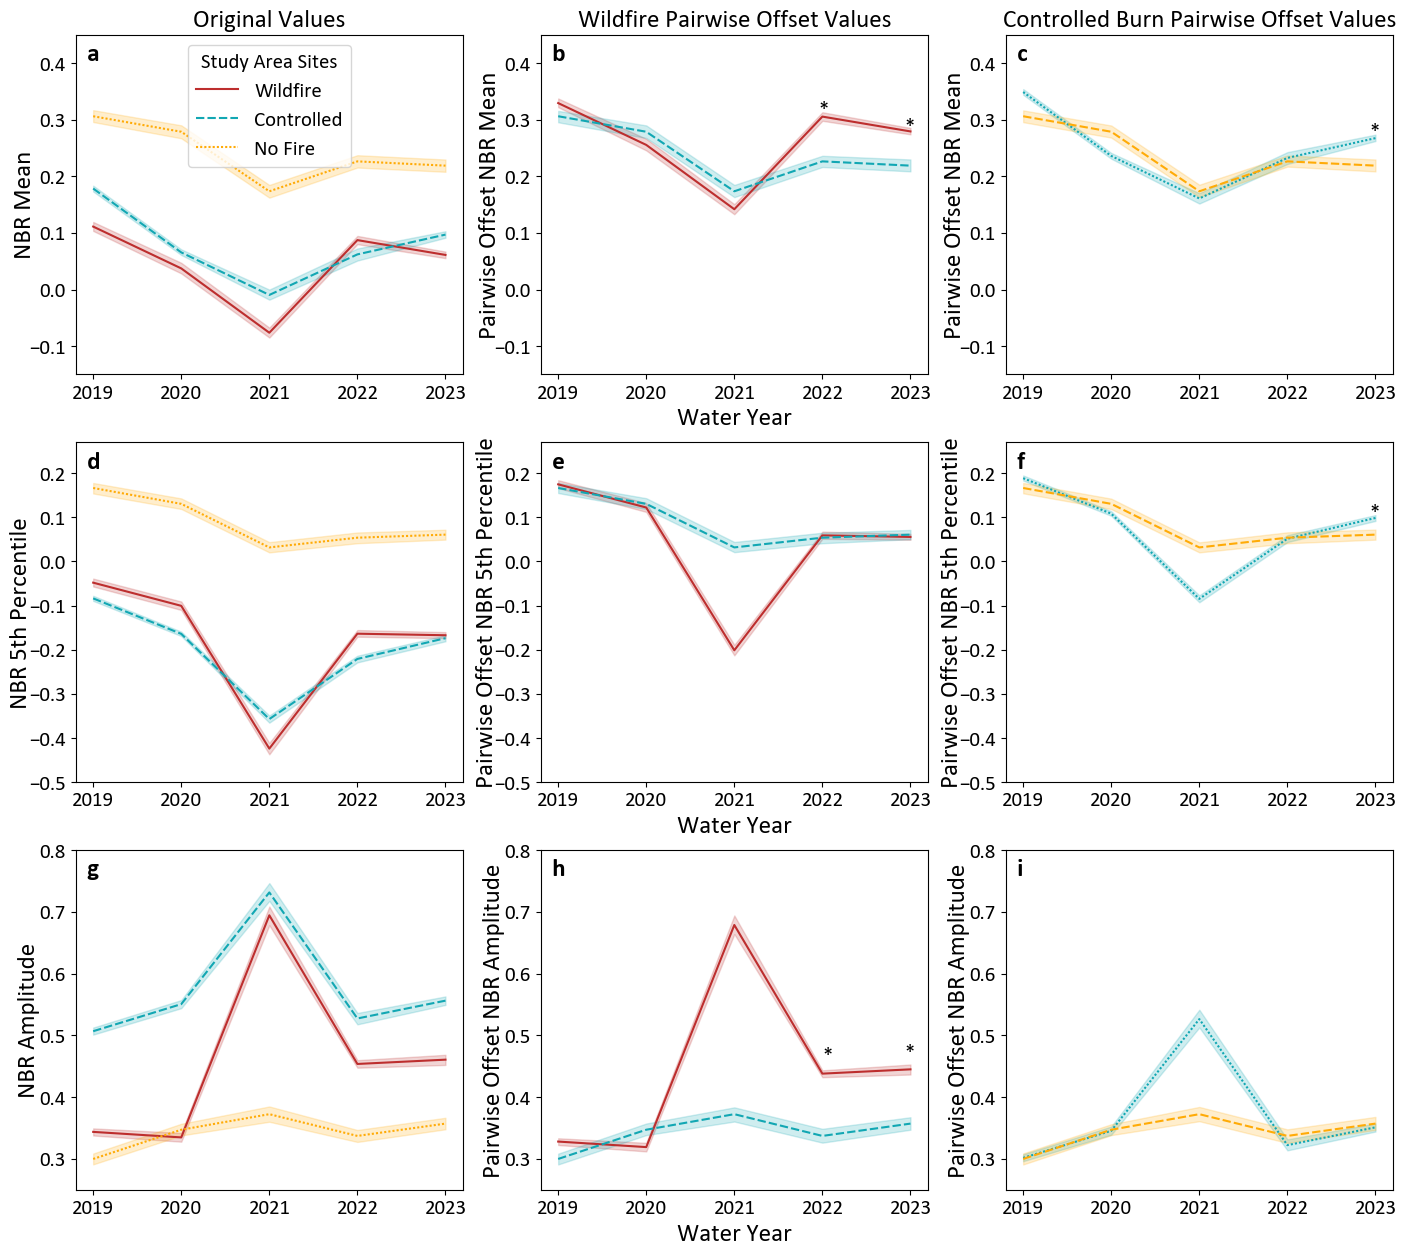

In [115]:
plt.rcParams["font.family"] = "Calibri"
SMALL_SIZE = 15
MEDIUM_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

fig, axes = plt.subplots(3, 3, figsize=(17, 15)) #, sharey='row') #sharex=True

plt.setp(axes[0], ylim=(-0.15, 0.45)) # for mean NBR
plt.setp(axes[1], ylim=(-0.5, 0.27)) # for min NBR
plt.setp(axes[2], ylim=(0.25, 0.8)) # for NBR amplitude

colorpalette = sns.color_palette(['#BD2E2E', '#12A7B3', '#FFAB07'])
wildfire_palette = sns.color_palette(['#BD2E2E', '#12A7B3'])
controlled_palette = sns.color_palette(['#12A7B3', '#FFAB07'])

# First Row - Mean NBR
sns.lineplot(ax=axes[0,0], data=offdf, x='WaterYear', y='NBR_RS_mean', hue='Site', style='Site', palette=colorpalette)
sns.lineplot(ax=axes[0,1], data=offdf[offdf['Site'] != 'Controlled'], x='WaterYear', y='NBR_RS_mean_offset', hue='Site', style='Site', palette=wildfire_palette, legend=False)
sns.lineplot(ax=axes[0,2], data=offdf[offdf['Site'] != 'Wildfire'], x='WaterYear', y='NBR_RS_mean_offset', hue='Site', style='Site', style_order=['', 'No Fire', 'Controlled'], palette=controlled_palette, legend=False)

axes[0,0].set(xlabel='', ylabel='NBR Mean')
axes[0,1].set(xlabel='Water Year', ylabel='Pairwise Offset NBR Mean')
axes[0,2].set(xlabel='', ylabel='Pairwise Offset NBR Mean')

# Second Row - 5th percentile NBR
sns.lineplot(ax=axes[1,0], data=offdf, x='WaterYear', y='NBR_RS_p5', hue='Site', style='Site', palette=colorpalette, legend=False)
sns.lineplot(ax=axes[1,1], data=offdf[offdf['Site'] != 'Controlled'], x='WaterYear', y='NBR_RS_p5_offset', hue='Site', style='Site', palette=wildfire_palette, legend=False)
sns.lineplot(ax=axes[1,2], data=offdf[offdf['Site'] != 'Wildfire'], x='WaterYear', y='NBR_RS_p5_offset', hue='Site', style='Site', style_order=['', 'No Fire', 'Controlled'], palette=controlled_palette, legend=False)

axes[1,0].set(xlabel='', ylabel='NBR 5th Percentile')
axes[1,1].set(xlabel='Water Year', ylabel='Pairwise Offset NBR 5th Percentile')
axes[1,2].set(xlabel='', ylabel='Pairwise Offset NBR 5th Percentile')

# Third Row - Amplitude NBR
sns.lineplot(ax=axes[2,0], data=offdf, x='WaterYear', y='NBR_RS_Amp', hue='Site', style='Site', palette=colorpalette, legend=False)
sns.lineplot(ax=axes[2,1], data=offdf[offdf['Site'] != 'Controlled'], x='WaterYear', y='NBR_RS_Amp_offset', hue='Site', style='Site', palette=wildfire_palette, legend=False)
sns.lineplot(ax=axes[2,2], data=offdf[offdf['Site'] != 'Wildfire'], x='WaterYear', y='NBR_RS_Amp_offset', hue='Site', style='Site', style_order=['', 'No Fire', 'Controlled'], palette=controlled_palette, legend=False)

axes[2,0].set(xlabel='', ylabel='NBR Amplitude')
axes[2,1].set(xlabel='Water Year', ylabel='Pairwise Offset NBR Amplitude')
axes[2,2].set(xlabel='', ylabel='Pairwise Offset NBR Amplitude')

# Figure titles
axes[0,0].legend(title='Study Area Sites')
axes[0,0].title.set_text('Original Values')
axes[0,1].title.set_text('Wildfire Pairwise Offset Values')
axes[0,2].title.set_text('Controlled Burn Pairwise Offset Values')

# Adding figure panel labels
axes[0,0].set_title('  a', y=0.9, loc='left', weight='bold')
axes[0,1].set_title('  b', y=0.9, loc='left', weight='bold')
axes[0,2].set_title('  c', y=0.9, loc='left', weight='bold')
axes[1,0].set_title('  d', y=0.9, loc='left', weight='bold')
axes[1,1].set_title('  e', y=0.9, loc='left', weight='bold')
axes[1,2].set_title('  f', y=0.9, loc='left', weight='bold')
axes[2,0].set_title('  g', y=0.9, loc='left', weight='bold')
axes[2,1].set_title('  h', y=0.9, loc='left', weight='bold')
axes[2,2].set_title('  i', y=0.9, loc='left', weight='bold')

# Adjusting y axis label padding
axes[0,0].yaxis.labelpad = -5
axes[0,1].yaxis.labelpad = -5
axes[0,2].yaxis.labelpad = -5
axes[1,0].yaxis.labelpad = -2
axes[1,1].yaxis.labelpad = -2.5
axes[1,2].yaxis.labelpad = -2.5
axes[2,0].yaxis.labelpad = 0
axes[2,1].yaxis.labelpad = 0
axes[2,2].yaxis.labelpad = 0

# Adding asterisks for significant differences in the two post-fire years
axes[0,1].text(2.95, 0.31, '*')
axes[0,1].text(3.93, 0.28, '*')
axes[0,2].text(3.93, 0.27, '*')
axes[1,2].text(3.93, 0.10, '*')
axes[2,1].text(3.00, 0.46, '*')
axes[2,1].text(3.93, 0.465, '*')

### Run statistical tests to test for significant difference between the three sites for each of these metrics

#### Test ANOVA assumptions

#### Test that the largest SD is not larger than 2x the smallest SD for each metric on each site
This is true, so my data meet this assumption

In [50]:
# offdf.groupby('Site').agg(np.std)

#### Test for normal distributions of each metric on each site
Everything appears fairly normally distriuted except for NBR_Amp and NBR_Amp_offset

In [50]:
# histos = offdf.hist(figsize=(12,12), bins=25)

The data are not normally distributed, I have p values less than 0.05 for every row/column pair (except for min nbr on the no fire site)

In [41]:
# offdf.groupby('Site').agg(stats.normaltest)

In [44]:
# from statsmodels.graphics.gofplots import qqplot
# from matplotlib import pyplot

# qqplot(offdf['NBR_p5'], line='s')
# pyplot.show()

#### Kruskal-Wallis Test = non-parametric ANOVA
- Doesn't assume the distributions of the dependent variables are normal
- Generally less powerful than ANOVA but should use it when assumptions aren't met
- Test shows if at least one site is different from the other two, use Dunn test for pairwise comparisons
- All three of my metrics are significantly different over the sites
- but this is not interesting really, since it's not filtered by year

In [46]:
testcol = 'NBR_RS_mean_offset'

# make site dfs
rxfire = offdf.loc[offdf['Site'] == 'Controlled']
wildfire = offdf.loc[offdf['Site'] == 'Wildfire']
nofire = offdf.loc[offdf['Site'] == 'No Fire']

F, p = stats.kruskal(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'Kruskal-Wallis test for {testcol}:\nF-Statistic={F:.4f}, p={p:.4f}')

Kruskal-Wallis test for NBR_RS_mean_offset:
F-Statistic=39.4653, p=0.0000


### Dunn test = post hoc pairwise comparisons for metrics
Not currently using this.

Adjusted p-values = adjusted for multiple comparisons

In [51]:
p_values = sp.posthoc_dunn(offdf, val_col=testcol, group_col='Site', sort=False)
# display(p_values)

# czu versus no, then czu vs rx, then no vs rx
p1 = p_values.loc['Wildfire', 'No Fire']
p2 = p_values.loc['Wildfire', 'Controlled']
p3 = p_values.loc['No Fire', 'Controlled']

reject = []
for p in [p1, p2, p3]:
    if p >= 0.05:
        reject.append("False - no sig diff")
    else:
        reject.append('True - sig diff')

print(f'Posthoc Dunn test for {testcol}')
print(f'Wildfire versus No Fire, {reject[0]}, p_Holm = {p1:0.4f}')
print(f'Wildfire versus Controlled, {reject[1]}, p_Holm = {p2:0.4f}')
print(f'Controlled  versus No Fire, {reject[2]}, p_Holm = {p3:0.4f}')

Posthoc Dunn test for NBR_RS_mean_offset
Wildfire versus No Fire, True - sig diff, p_Holm = 0.0000
Wildfire versus Controlled, True - sig diff, p_Holm = 0.0002
Controlled  versus No Fire, True - sig diff, p_Holm = 0.0099


### Mann Whitney U test (non-parametric t test) for post-fire years, offset values

In [52]:
testyear = '2023'
testcol = 'NBR_RS_Amp_offset'
# display(offdf)

rxtest = rxfire[rxfire['WaterYear'] == testyear][testcol]
notest = nofire[nofire['WaterYear'] == testyear][testcol]
czutest = wildfire[wildfire['WaterYear'] == testyear][testcol]

U1, p = stats.mannwhitneyu(rxtest, notest)
U1b, pb = stats.mannwhitneyu(czutest, notest)

print(f'Mann Whitney U test for {testcol} in {testyear}, controlled burn versus reference:\nU={U1:.2f}, p={p:.6f}')
print(f'\nMann Whitney U test for {testcol} in {testyear}, wildfire versus reference:\nU={U1b:.2f}, p={pb:.6f}')

Mann Whitney U test for NBR_RS_Amp_offset in 2023, controlled burn versus reference:
U=20069.00, p=0.952754

Mann Whitney U test for NBR_RS_Amp_offset in 2023, wildfire versus reference:
U=33387.00, p=0.000000


## Get annual metrics summarized across the three sites or sites x veg

In [67]:
# I can use studyarea (three sites) or cover_polys (three sites x three veg types)
regions = cover_polys
# regions = studyarea
# when you change this, you still have to make edits to two lines of the altair chart

if regions == studyarea: #change alt.Color and Alt.Tooltip to 'Site' instead of 'Site_Veg'
    dom = ['Controlled Burn', 'Wildfire', 'No Fire'] 
    rng = ['darkorange', 'firebrick', 'slateblue']
else: #change alt.Color and Alt.Tooltip to 'Site_Veg' instead of 'Site'
    dom = ['Grass: Controlled', 'Grass: Wildfire', 'Grass: No Fire', \
           'Shrub: Controlled', 'Shrub: Wildfire', 'Shrub: No Fire'] #, \
#            'Tree: Wildfire', 'Tree: No Fire']
    rng = ['darkgreen', 'teal', 'lightgreen', \
           'saddlebrown', 'darkorange', 'khaki'] #, \
#            'mediumpurple', 'plum']

In [57]:
# select which bands to reduce
# VIs = NBR, EVI, NDVI, NDMI, NDWI
# metrics: _Amp, _MA_Amp, _mean, _median, _p5, _p95, _moving_average_mean/median/p5/p95
# more metrics: 'NBR_first', 'NBR_LSG_mean', 'NBR_LSG_median', 'NBR_LSG_p95', 'NBR_moving_average_LSG_mean'
metrics = ['NBR_Amp', 'NBR_MA_Amp', 'NBR_RS_mean'] #, 'NBR_LSG_median']
annualMetricsSelected = annualMetrics.select(metrics)

# can reduce by mean or median
# for every image, you get a fc with site, and those mean values as properties.
# need to set Date of each feature in the collection
def RR_all_features(img):
    fc_means = ee.FeatureCollection(img.reduceRegions(regions, ee.Reducer.mean(), 20))
    img_date = img.date().format("MM-dd-YYYY")
    img_wy = img.get('system:index')
    def set_date(feat):
        return feat.set({'Date': img_date, 'WaterYear': img_wy})
    fc_means = ee.FeatureCollection(fc_means.map(set_date))
    return fc_means

# map over each image in the collection to call reduceRegions
# creates a collection of feature collections, has to be flattened
result = ee.FeatureCollection(annualMetricsSelected.map(RR_all_features)).flatten()

df = geemap.ee_to_df(result)

# COMMENT OUT THIS LINE IF USING REGULAR ANNUAL METRICS
df['WaterYear'] = df['WaterYear'].str[2:]

# display(df)

### Plot the annual metrics across the three sites
No error bars bc it's a spatial mean

In [58]:
ts = df
ts.Date = pd.to_datetime(ts.Date, format='%m-%d-%Y')
ts.WaterYear = pd.to_datetime(ts.WaterYear, format='%Y')

# multi series line chart
line = alt.Chart(ts).mark_line().encode(
    x = alt.X('WaterYear', axis=alt.Axis(title='Water Year', format="%Y", labelAngle=-45)),
    y = alt.Y('NBR_RS_mean', axis=alt.Axis(title='NBR_RS_mean')), #scale=alt.Scale(domain=(1, -1)),
    color=alt.Color('Site_Veg', legend=alt.Legend(title="Site"), scale=alt.Scale(domain=dom, range=rng)),
    tooltip = [
      alt.Tooltip('WaterYear:T', title='Water Year', format='%Y'),
      alt.Tooltip('Site_Veg', title='Site'),
      alt.Tooltip('NBR_mean:Q', title='NBR_mean')
    ]
).properties(height=450, width=500).interactive()
line

# create layered chart
alt.layer(line
          ).configure_legend(labelFontSize=14,
                             titleFontSize=14,
                             symbolSize = 200,
                             strokeColor='gray',
                             fillColor='#FFFFFF',
                             padding=10,
                             cornerRadius=1,
                             orient='top-right'
          ).configure_axis(
                labelFontSize=14,
                titleFontSize=14
          ).interactive().resolve_scale(color='independent')

alt.LayerChart(...)

This is cool but it feels more important to analyze how each of these metrics varies for one site at a time

# 4. Vegetation Analysis (by pixel)

### Stratify by cover type
This uses a shapefile created in arcgis pro based on a supervised classification of the 2020 NAIP image, before both fires

In [59]:
cover = geopandas.read_file(cover_pixels_shp)
cover.drop(columns=['FID_StudyA', 'OBJECTID', 'FID_Sent_1', \
                    'AREA', 'Shape_Leng', 'Shape_Area'], inplace=True)
pd.set_option('display.min_rows', 100)

In [60]:
# cover.plot()
# cover.describe() 
# cover.info() #dtypes

#### Rework the table to have percentage cover columns for grass, shrubs, and trees

In [61]:
cover['Dominant'] = pd.cut(x=cover.MAJORITY, bins=[-1,0,1,2], labels=['Shrub', 'Tree', 'Grass'])
cover['LeastDom'] = pd.cut(x=cover.MINORITY, bins=[-1,0,1,2], labels=['Shrub', 'Tree', 'Grass'])
# capture any remaining percentage cover
cover['PerRemain'] = np.where(cover['MINORITY_P'] + cover['MAJORITY_P'] < 100, 100 - cover['MAJORITY_P'] - cover['MINORITY_P'], 0)
# display(cover)

In [62]:
# when grass is dominant, assign it the majority percentage value
cover['Grass'] = np.where(cover['Dominant'] == 'Grass', cover['MAJORITY_P'], 0)
# when grass is least dominant, assign it the minority percentage value
cover['Grass'] = np.where((cover['LeastDom'] == 'Grass') & (cover['Dominant'] != 'Grass'), cover['MINORITY_P'], cover['Grass'])
# otherwise, set to remaining percentage
cover['Grass'] = np.where((cover['LeastDom'] != 'Grass') & (cover['Dominant'] != 'Grass'), cover['PerRemain'], cover['Grass'])


# when shrub is dominant, assign it the majority percentage value
cover['Shrub'] = np.where(cover['Dominant'] == 'Shrub', cover['MAJORITY_P'], 0)
# when grass is least dominant, assign it the minority percentage value
cover['Shrub'] = np.where((cover['LeastDom'] == 'Shrub') & (cover['Dominant'] != 'Shrub'), cover['MINORITY_P'], cover['Shrub'])
# otherwise, set to remaining percentage
cover['Shrub'] = np.where((cover['LeastDom'] != 'Shrub') & (cover['Dominant'] != 'Shrub'), cover['PerRemain'], cover['Shrub'])

# assign tree any remaining percentage cover
cover['Tree'] = np.where(cover['Grass'] + cover['Shrub'] < 100, 100 - cover['Grass'] - cover['Shrub'], 0)

In [63]:
# Cleaning up the df
cover['Site'] = cover['TREATMENT_']
cover.drop(columns=['Dominant', 'LeastDom', 'PerRemain', 'MAJORITY', 'MAJORITY_P',\
                    'MINORITY', 'MINORITY_P', 'TREATMENT_'], inplace=True)
# Create a column for the cover type if 60% or more
cover['CoverType'] = np.where(cover['Grass'] >= 60.0, 'Grass', 'Mix')
cover['CoverType'] = np.where(cover['Shrub'] >= 60.0, 'Shrub', cover['CoverType'])
cover['CoverType'] = np.where(cover['Tree'] >= 60.0, 'Tree', cover['CoverType'])

print(cover.dtypes)
# cover.crs #EPSG:32610
# cover.describe()
# cover.head()
# display(cover)

FID_Sentin       int64
geometry      geometry
Grass          float64
Shrub          float64
Tree           float64
Site            object
CoverType       object
dtype: object


#### Using the 60% cover cut-off for pixels included in the stratified analysis
At the 60% cover level: 
- Tree = 46
- Shrub = 997
- Grass = 8205
- Mix = 545

At the 80% cover level: 
- Tree = 20
- Shrub = 554
- Grass = 7449
- Mix = 1770

In [64]:
# cover['CoverType'].str.contains('Tree').value_counts()

#### Get annual metrics by these cover pixels 

In [65]:
# convert to points using polygon's centroid, not using this right now
# points = cover.copy()
# points['geometry'] = points['geometry'].centroid
# points.head()

### Test if mean veg type cover is significantly diff across the thtree sites before the fire

In [67]:
# cover_test = cover[['Grass', 'Shrub', 'Tree', 'Site']]
# cover_test.head(5)

#### Check assumptions for ANOVA
 - #### Test that the largest SD is not larger than 2x the smallest SD for each metric on each site
This is not true only for trees on the controlled burn site
- #### Test for normal distributions of each metric on each site
Nothing looks normally distriuted
- #### Data are non normal

In [68]:
# cover_test.groupby('Site').agg(np.std)
# histos = cover_test.groupby('Site').hist(bins=25)
# cover_test.groupby('Site').agg(stats.normaltest)

#### Run a Kruskal Wallis test for comparing non-normal distributions
- Doesn't assume the distributions of the dependent variables are normal
- Generally less powerful than ANOVA but should use it when assumptions aren't met
- Test shows if at least one site is different from the other two, use Dunn test for pairwise comparisons

In [69]:
testcol = 'Tree'

# make site dfs
rxfire = cover_test.loc[cover_test['Site'] == 'Controlled']
wildfire = cover_test.loc[cover_test['Site'] == 'Wildfire']
nofire = cover_test.loc[cover_test['Site'] == 'No fire']

F, p = stats.kruskal(rxfire[testcol], wildfire[testcol], nofire[testcol])
print(f'Kruskal-Wallis test for {testcol}:\nF-Statistic={F:.4f}, p={p:.4f}')
cover_test.groupby('Site').agg(np.mean)
# print(len(cover_test.index))

Kruskal-Wallis test for Tree:
F-Statistic=946.4688, p=0.0000


,Grass,Shrub,Tree
Site,,,
Controlled,93.142922,6.698452,0.158627
No fire,55.431055,41.310837,3.258113
Wildfire,90.024414,9.032732,0.942855


### Dunn test = post hoc pairwise comparisons for vegetation cover
Adjusted p-values = adjusted for multiple comparisons

In [71]:
p_values = sp.posthoc_dunn(cover_test, val_col=testcol, group_col='Site', sort=False, p_adjust='bonferroni')
# display(p_values)

# czu versus no, then czu vs rx, then no vs rx
p1 = p_values.loc['Wildfire', 'No fire']
p2 = p_values.loc['Wildfire', 'Controlled']
p3 = p_values.loc['No fire', 'Controlled']

reject = []
for p in [p1, p2, p3]:
    if p >= 0.05:
        reject.append("False - no sig diff")
    else:
        reject.append('True - sig diff')

print(f'Posthoc Dunn test for {testcol}')
print(f'Wildfire versus No Fire, {reject[0]}, p_bonf = {p1:0.5f}')
print(f'Wildfire versus Controlled, {reject[1]}, p_bonf = {p2:0.5f}')
print(f'Controlled  versus No Fire, {reject[2]}, p_bonf = {p3:0.5f}')

Posthoc Dunn test for Tree
Wildfire versus No Fire, True - sig diff, p_bonf = 0.00000
Wildfire versus Controlled, False - no sig diff, p_bonf = 0.80199
Controlled  versus No Fire, True - sig diff, p_bonf = 0.00000


### Sample all 9793 pixels
This works but may cause the notebook to crash when you load the resulting df

In [72]:
# # select bands to sample
# # VIs = NBR, EVI, NDVI, NDMI, NDWI
# # metrics = _Amp, _MA_Amp, _kurtosis, _mean, _median, _p5, _p95, _skew, _moving_average_kurtosis/mean/median/p5/p95/skew.
# metrics = ['NBR_Amp', 'NBR_p5', 'NBR_p95', 'NBR_mean']
# # metrics = ['EVI_Amp', 'EVI_p5', 'EVI_p95', 'EVI_mean']
# annualMetricsSelected = annualMetrics.select(metrics)

# # diff version with chunk_cover as the region
# def RR_all_features(img):
#     fc_means = ee.FeatureCollection(img.reduceRegions(chunk_cover, ee.Reducer.mean(), 20))
#     img_date = img.date().format("MM-dd-YYYY")
#     img_wy = img.get('system:index')
#     def set_date(feat):
#         return feat.set({'Date': img_date, 'WaterYear': img_wy})
#     fc_means = ee.FeatureCollection(fc_means.map(set_date))
#     return fc_means

# # Separate the points into chunks of 1000, run reduceRegions to get stats, and then recombine into one df
# chunks = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
# add_dfs = []

# for i in range(len(chunks)-1):
#     chunk_cover = cover.iloc[chunks[i]:chunks[i+1]] # sub-sample the full df 
#     chunk_cover = geemap.geopandas_to_ee(chunk_cover) # convert to ee fc
#     result = ee.FeatureCollection(annualMetricsSelected.map(RR_all_features)).flatten()
#     chunk_df = geemap.ee_to_df(result)
#     add_dfs.append(chunk_df)
    
# recombined_dfs = pd.concat(add_dfs, ignore_index=True)

# # save as a csv to not have to do it again each time, this is a big file
# filename = r'D:/1_AMLT/11_Chapter4/AnnualMetrics_perS2Pixel_NBR_122023.csv'
# recombined_dfs.to_csv(filename)

### Take a sub-sample
- Take 200 random points for each site/cover combo when possible
- When there are fewer than 200 points of a certain cover within a site, take all points
- Combine them back together

In [74]:
# Take 200 grass points from each site randomly
cover_grass = cover.loc[cover['CoverType'] == 'Grass']
cover_grass = cover_grass.groupby('Site', group_keys=False).apply(lambda x: x.sample(n=200)) #add random_state=1 for reproducibility

# Take all tree points
cover_tree = cover.loc[cover['CoverType'] == 'Tree']
# print(cover_tree.groupby('Site').count()) #see how many there are by site

# Shrub - take all 168 from Controlled site, all 139 from Wildfire site, then sample 200 from No fire site (of 690) 
cover_shrub = cover.loc[cover['CoverType'] == 'Shrub']
cover_shrub_takeall = cover_shrub.loc[(cover_shrub['Site'] == 'Controlled') | (cover_shrub['Site'] == 'Wildfire')]
cover_shrub_nofiresample = cover_shrub.loc[cover_shrub['Site'] == 'No fire'].sample(n=200)
cover_shrub = pd.concat([cover_shrub_takeall, cover_shrub_nofiresample])
# print(cover_shrub.groupby('Site').count())

sub_cover = pd.concat([cover_grass, cover_shrub, cover_tree])
sub_cover.describe()

,FID_Sentin,Grass,Shrub,Tree
count,1153.000000,1153.000000,1153.000000,1153.000000
mean,85459.660017,56.122859,39.883606,3.993539
std,20768.127342,40.077844,38.481090,16.039316
min,40446.000000,0.000000,0.000000,0.000000
25%,71233.000000,16.544100,0.735300,0.000000
50%,81185.000000,66.796900,24.913500,0.000000
75%,92367.000000,98.961900,76.470600,0.000000
max,167919.000000,100.000000,100.000000,100.000000


### Sample imagery data to the smaller sample of pixels

In [75]:
%%time
# select bands to sample
# VIs: NBR, EVI, NDVI, NDMI, NDWI
# metrics: _Amp, _MA_Amp, _mean, _median, _p5, _p95, _moving_average_mean/median/p5/p95
# more metrics: 'NBR_first', 'NBR_LSG_mean', 'NBR_LSG_median', 'NBR_LSG_p95', 'NBR_moving_average_LSG_mean'
metrics = ['NBR_RS_Amp', 'NBR_RS_p5', 'NBR_RS_p95', 'NBR_RS_mean'] #, 'NBR_first', 'NBR_LSG_mean', 'NBR_LSG_median'
# metrics = ['EVI_Amp', 'EVI_p5', 'EVI_p95', 'EVI_mean']
annualMetricsSelected = annualMetrics.select(metrics)

# diff version with chunk_cover as the region
def RR_all_features(img):
    fc_means = ee.FeatureCollection(img.reduceRegions(chunk_cover, ee.Reducer.mean(), 10))
    img_date = img.date().format("MM-dd-YYYY")
    img_wy = img.get('system:index')
    def set_date(feat):
        return feat.set({'Date': img_date, 'WaterYear': img_wy})
    fc_means = ee.FeatureCollection(fc_means.map(set_date))
    return fc_means

# Separate the points into chunks of 1000, run reduceRegions to get stats, and then recombine into one df
chunks = [0, 1000, 2000]
add_dfs = []

for i in range(len(chunks)-1):
    chunk_cover = sub_cover.iloc[chunks[i]:chunks[i+1]] # sub-sample the full df 
    chunk_cover = geemap.geopandas_to_ee(chunk_cover) # convert to ee fc
    result = ee.FeatureCollection(annualMetricsSelected.map(RR_all_features)).flatten()
    chunk_df = geemap.ee_to_df(result)
    add_dfs.append(chunk_df)
    
recombined_dfs = pd.concat(add_dfs, ignore_index=True)

# If using REGULAR annual metrics, comment this out
recombined_dfs['WaterYear'] = recombined_dfs['WaterYear'].str[2:]

CPU times: total: 1.52 s
Wall time: 2min 9s


In [76]:
# Convert from water year to years from fire
recombined_dfs['YearsFromFire'] = recombined_dfs.apply(yearsfromfire, axis=1)

# recombined_dfs.head(10)

## Plot the differences in a band value across the veg types and three sites - Figure 5

Text(0.0, 0.9, '  i')

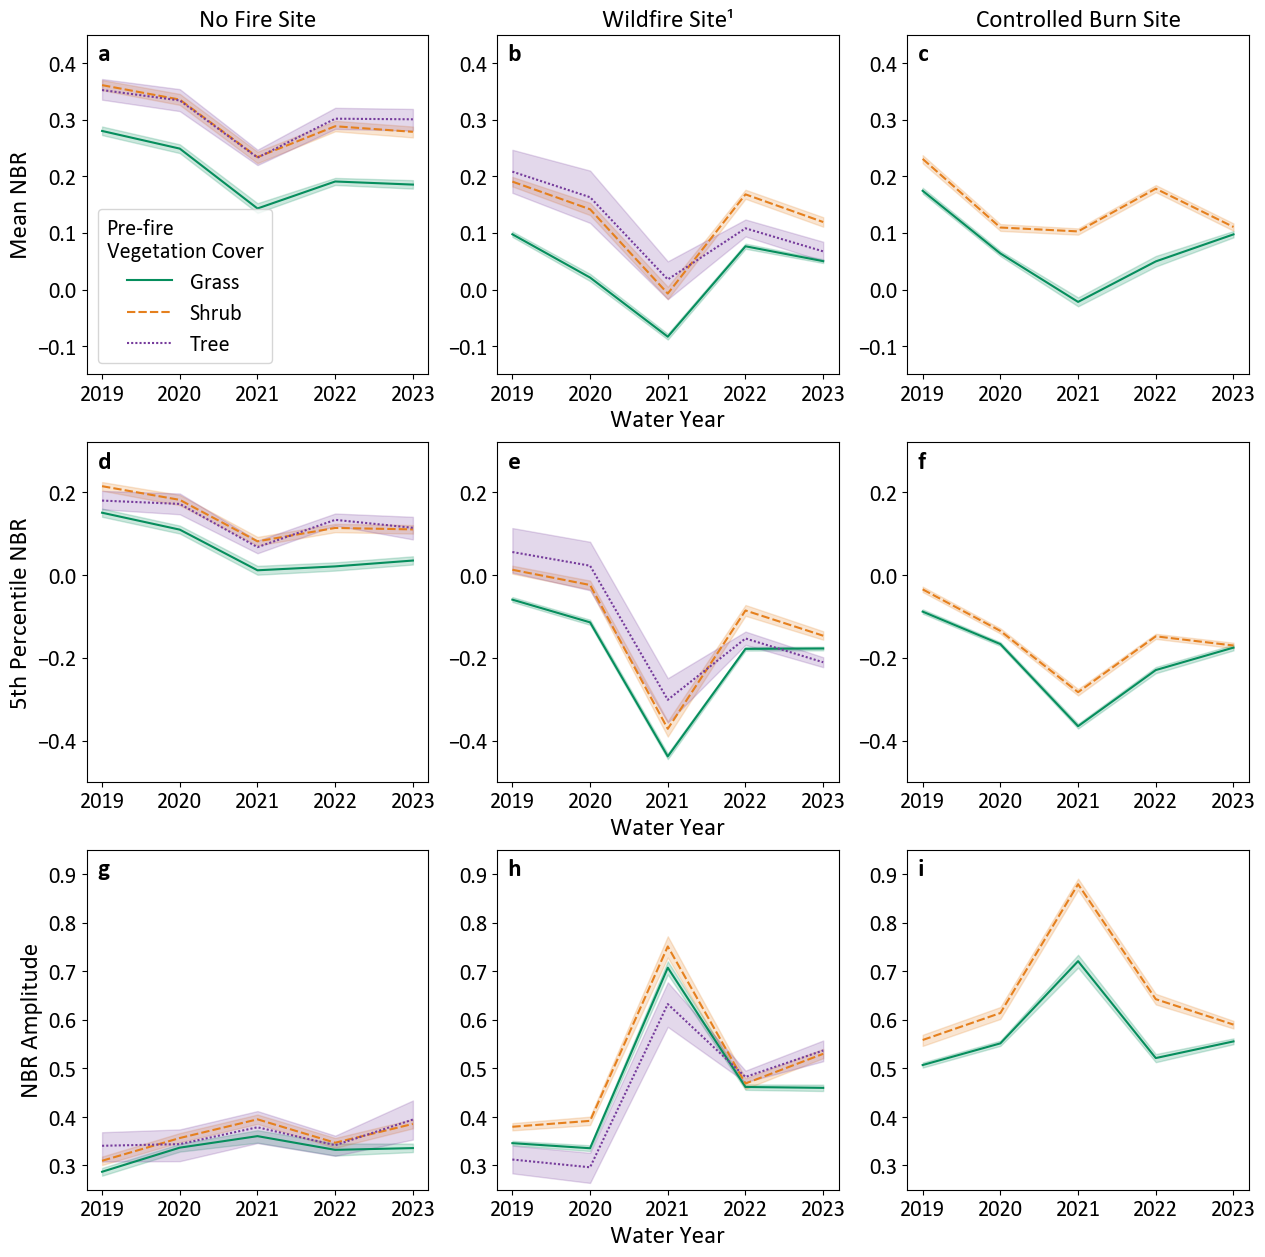

In [78]:
df = recombined_dfs

plt.rcParams["font.family"] = "Calibri"
SMALL_SIZE = 16
MEDIUM_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

colorpalette = sns.color_palette(['#068E5D', '#E5801E', '#763C9C']) #checked that these are color vision safe

plt.setp(axes[0], ylim=(-0.15, 0.45)) # for mean NBR
plt.setp(axes[1], ylim=(-0.5, 0.32)) # for min NBR
plt.setp(axes[2], ylim=(0.25, 0.95)) # for NBR amplitude

# fig.suptitle('Figure title')

# First Row - Mean NBR
sns.lineplot(ax=axes[0,0], data=df.loc[df['Site'] == 'No fire'], x='WaterYear', y='NBR_RS_mean', hue='CoverType', style='CoverType', palette=colorpalette)
axes[0,0].title.set_text('No Fire Site')
axes[0,0].legend(title='Pre-fire\nVegetation Cover', loc='lower left')

sns.lineplot(ax=axes[0,1], data=df.loc[df['Site'] == 'Wildfire'], x='WaterYear', y='NBR_RS_mean', hue='CoverType', style='CoverType', palette=colorpalette)
axes[0,1].title.set_text('Wildfire Site\u00b9')
axes[0,1].get_legend().remove()

sns.lineplot(ax=axes[0,2], data=df.loc[df['Site'] == 'Controlled'], x='WaterYear', y='NBR_RS_mean', hue='CoverType', style='CoverType', palette=colorpalette)
axes[0,2].title.set_text('Controlled Burn Site')
axes[0,2].get_legend().remove()

# Second Row - Min NBR
sns.lineplot(ax=axes[1,0], data=df.loc[df['Site'] == 'No fire'], x='WaterYear', y='NBR_RS_p5', hue='CoverType', style='CoverType', palette=colorpalette)
axes[1,0].get_legend().remove()

sns.lineplot(ax=axes[1,1], data=df.loc[df['Site'] == 'Wildfire'], x='WaterYear', y='NBR_RS_p5', hue='CoverType', style='CoverType', palette=colorpalette)
axes[1,1].get_legend().remove()

sns.lineplot(ax=axes[1,2], data=df.loc[df['Site'] == 'Controlled'], x='WaterYear', y='NBR_RS_p5', hue='CoverType', style='CoverType', palette=colorpalette)
axes[1,2].get_legend().remove()

# Third Row - NBR Amplitude
sns.lineplot(ax=axes[2,0], data=df.loc[df['Site'] == 'No fire'], x='WaterYear', y='NBR_RS_Amp', hue='CoverType', style='CoverType', palette=colorpalette)
axes[2,0].get_legend().remove()

sns.lineplot(ax=axes[2,1], data=df.loc[df['Site'] == 'Wildfire'], x='WaterYear', y='NBR_RS_Amp', hue='CoverType', style='CoverType', palette=colorpalette)
axes[2,1].get_legend().remove()

sns.lineplot(ax=axes[2,2], data=df.loc[df['Site'] == 'Controlled'], x='WaterYear', y='NBR_RS_Amp', hue='CoverType', style='CoverType', palette=colorpalette)
axes[2,2].get_legend().remove()

axes[0,0].set(xlabel='', ylabel='Mean NBR')
axes[0,1].set(xlabel='Water Year', ylabel='')
axes[0,2].set(xlabel='', ylabel='')
axes[1,0].set(xlabel='', ylabel='5th Percentile NBR')
axes[1,1].set(xlabel='Water Year', ylabel='')
axes[1,2].set(xlabel='', ylabel='')
axes[2,0].set(xlabel='', ylabel='NBR Amplitude')
axes[2,1].set(xlabel='Water Year', ylabel='')
axes[2,2].set(xlabel='', ylabel='')

# Adding figure panel labels
axes[0,0].set_title('  a', y=0.9, loc='left', weight='bold')
axes[0,1].set_title('  b', y=0.9, loc='left', weight='bold')
axes[0,2].set_title('  c', y=0.9, loc='left', weight='bold')
axes[1,0].set_title('  d', y=0.9, loc='left', weight='bold')
axes[1,1].set_title('  e', y=0.9, loc='left', weight='bold')
axes[1,2].set_title('  f', y=0.9, loc='left', weight='bold')
axes[2,0].set_title('  g', y=0.9, loc='left', weight='bold')
axes[2,1].set_title('  h', y=0.9, loc='left', weight='bold')
axes[2,2].set_title('  i', y=0.9, loc='left', weight='bold')